### 스마일게이트 UnsmileData Pretrained model 사용해보기

In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import random


참고자료: https://github.com/smilegate-ai/korean_unsmile_dataset

In [2]:
from datasets import load_dataset
datasets = load_dataset('smilegate-ai/kor_unsmile')

Using custom data configuration smilegate-ai--kor_unsmile-e0f75c6e3be1af78
Reusing dataset parquet (/Users/sonak_bee/.cache/huggingface/datasets/parquet/smilegate-ai--kor_unsmile-e0f75c6e3be1af78/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
print(datasets)

DatasetDict({
    train: Dataset({
        features: ['문장', '여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean', '개인지칭', 'labels'],
        num_rows: 15005
    })
    valid: Dataset({
        features: ['문장', '여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean', '개인지칭', 'labels'],
        num_rows: 3737
    })
})


실제 훈련된 모델은 '개인지칭'과 'label'은 빠져있음.
'개인지칭'의 경우 추가 정보(개인을 지칠할 경우 모욕적일 수도 있어서..?)

In [4]:
from transformers import TextClassificationPipeline, BertForSequenceClassification, AutoTokenizer
model_name = 'smilegate-ai/kor_unsmile'
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = TextClassificationPipeline(
        model = model,
        tokenizer = tokenizer,
        device = -1,   # cpu: -1, gpu: gpu number
        return_all_scores = True,
        function_to_apply = 'sigmoid'
    )


In [5]:
# 예시 문장
for result in pipe("남자는 ㅁㅊ")[0]:
    print(result)

{'label': '여성/가족', 'score': 0.12207836657762527}
{'label': '남성', 'score': 0.09492329508066177}
{'label': '성소수자', 'score': 0.010032283142209053}
{'label': '인종/국적', 'score': 0.005269773304462433}
{'label': '연령', 'score': 0.008836937136948109}
{'label': '지역', 'score': 0.013589856214821339}
{'label': '종교', 'score': 0.0068999845534563065}
{'label': '기타 혐오', 'score': 0.02216210402548313}
{'label': '악플/욕설', 'score': 0.4475053548812866}
{'label': 'clean', 'score': 0.13134682178497314}


갖고 있는 데이터로 테스트

In [6]:
import numpy as np
import pandas as pd

In [7]:
df3 = pd.read_csv('/Users/sonak_bee/Desktop/정의당/정의당result.csv', encoding='utf-8')

In [8]:
result1 = []
for t in df3['Text'].astype(str):
    result1.extend(pipe(t))

In [9]:
# 결과 예시
result1[0]

[{'label': '여성/가족', 'score': 0.022844361141324043},
 {'label': '남성', 'score': 0.010091505944728851},
 {'label': '성소수자', 'score': 0.017089826986193657},
 {'label': '인종/국적', 'score': 0.01382347010076046},
 {'label': '연령', 'score': 0.008108662441372871},
 {'label': '지역', 'score': 0.0183172095566988},
 {'label': '종교', 'score': 0.010279661975800991},
 {'label': '기타 혐오', 'score': 0.013024509884417057},
 {'label': '악플/욕설', 'score': 0.05570340156555176},
 {'label': 'clean', 'score': 0.8967586755752563}]

In [10]:
label =  ['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean']

In [11]:
score = [[item['score'] for item in i] for i in result1]

In [12]:
score = np.round(score,2)

In [13]:
new_df = pd.DataFrame(score, columns=label)


In [14]:
# df에 text열 추가 - 텍스트와 같이 보고 싶을 경우
new_df = pd.DataFrame(score, columns=label)
new_df['result'] = new_df.idxmax(axis = 1)
new_df.insert(0, 'text', df3['Text']) # 앞에 숫자가 순서(왼쪽->오른쪽)

new_df.head()

,text,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,result
0,정의당 지지하는 유권자 여러분! 여러분의 아픔과 진정성에 공감합니다. 그러나 투표는...,0.02,0.01,0.02,0.01,0.01,0.02,0.01,0.01,0.06,0.90,clean
1,아 ㅋㅋㅋㅋ 근데 어느 당 참관인 분인진 모르겠는데 정의당 참관인 분이 붉은 코트 ...,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.08,0.88,clean
2,난 정의당이 본인들 잘못이 무엇인지 알고 있는 바에야 후보를 안내거나 다른 후보를 ...,0.02,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.15,0.76,clean
3,정의당 유세뛴 친구한테 심찍었지만 이재명 지지할수밖에 없는 이 상황을 토로함,0.02,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.11,0.84,clean
4,윤석열 진다는 찌라시라도 돌았나 왜이러시나 갑자기 정의당 https://t.co/0...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.59,0.39,악플/욕설


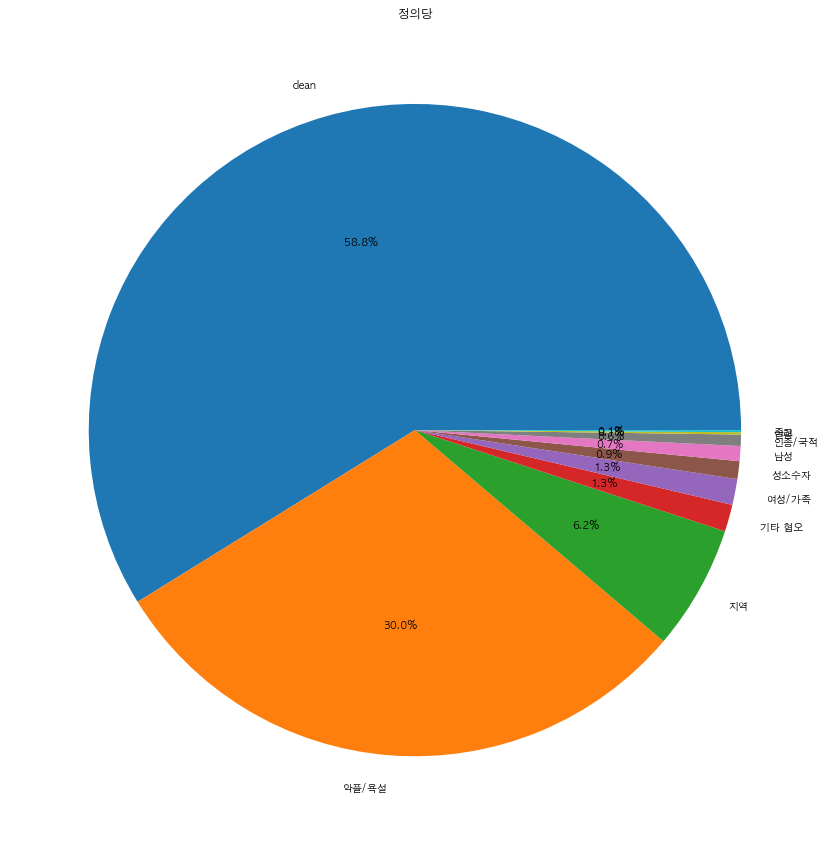

In [15]:
plt.rcParams['font.family'] = 'AppleGothic'
import matplotlib.pyplot as plt
plt.figure(figsize = (20,15))
plt.title('정의당')
plt.pie(new_df['result'].value_counts()/len(new_df),
        labels = new_df['result'].unique(),
        autopct = '%.1f%%')
plt.show()

In [15]:
new_df.to_csv("./정의당_unsmile.csv", encoding='utf-8-sig',sep=',', index=False)

In [30]:
female = new_df[new_df['여성/가족']>=0.60]

In [31]:
female

,text,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean
73,2번 좆석이 무리 막는다고 절박재명 ⁶아묻따⁹ 지지하는게 맞나...? 무지성 여가부...,0.65,0.02,0.02,0.02,0.01,0.02,0.01,0.05,0.24,0.13
147,"D-1, 대학가 누빈 심상정 ""다당제·성평등 위해 투표"" #여성 #정의당 #심상정 ...",0.86,0.02,0.03,0.03,0.01,0.02,0.01,0.05,0.06,0.14
153,심상정 페미니즘이 교양인 시절도 있었다고...\n정의당을 보면 페미니즘이 패션이 된...,0.78,0.01,0.02,0.04,0.01,0.01,0.01,0.03,0.05,0.29
160,@sidagaso 정의당은 삼류 정당입니다.진보정당을 표방했으나 어느 순간부터 페미...,0.61,0.01,0.02,0.02,0.01,0.01,0.01,0.07,0.14,0.21
175,에이씨 불꽃 박지현님 보다가 민주당 다른 남자 젊은 정치인들 보면 진짜 화딱지난다....,0.63,0.02,0.02,0.02,0.01,0.04,0.00,0.07,0.18,0.18
...,...,...,...,...,...,...,...,...,...,...,...
8592,@banachopie 트페미들은 민주당이나 정의당 당직자가 아닌가 싶을 정도네요 아...,0.84,0.01,0.03,0.04,0.01,0.01,0.02,0.07,0.09,0.13
8621,"정의당이 노동을 버리고 페미를 선택한 결과\n\n정의, 한국노총 李 지지 선언에 ""...",0.74,0.01,0.01,0.03,0.01,0.02,0.01,0.06,0.11,0.18
8630,"메갈정의당은 고 노회찬의원의 사망과 함께 사망선고를 받은 정당!!!\n만일, 노회찬...",0.66,0.01,0.01,0.03,0.01,0.02,0.01,0.03,0.09,0.37
8644,게다가 여성가산점 청년비례 이딴식으로 류호정 장혜영같이 무능력자들에게 국회의원직을 ...,0.61,0.01,0.02,0.05,0.01,0.04,0.01,0.23,0.26,0.09


In [32]:
import re
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [33]:
female['text'] = female['text'].apply(lambda x:clean_text(x))
female['selected_text'] = female['text'].apply(lambda x:clean_text(x))

In [34]:
female['temp_list'] = female['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in female['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,정의당,135
1,정의당은,54
2,민주당,45
3,여성,41
4,정의당이,40
5,심상정,36
6,진짜,35
7,수,33
8,이재명,26
9,페미니즘,25


In [43]:
def remove_stopword(x):
    return [y for y in x if y not in ['것','정의당은','정의당이','그','더','다','표','안','거','수','게','위해','좀','진짜','하는','왜']]
female['temp_list'] = female['selected_text'].apply(lambda x:remove_stopword(x))

In [48]:
top = Counter([item for sublist in female['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,정의당은,54
2,민주당,45
3,여성,41
4,정의당이,40
5,심상정,36
6,진짜,35
7,수,33
8,이재명,26
9,페미니즘,25
10,왜,25


In [49]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [50]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

/Users/sonak_bee/miniforge3/envs/sonak/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [52]:
minju = female[female['text'].str.contains('민주당')]
minju[:20]

,text,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,selected_text,temp_list
175,에이씨 불꽃 박지현님 보다가 민주당 다른 남자 젊은 정치인들 보면 진짜 화딱지난다 ...,0.63,0.02,0.02,0.02,0.01,0.04,0.00,0.07,0.18,0.18,에이씨 불꽃 박지현님 보다가 민주당 다른 남자 젊은 정치인들 보면 진짜 화딱지난다 ...,"[에이씨, 불꽃, 박지현님, 보다가, 민주당, 다른, 남자, 젊은, 정치인들, 보면..."
243,정의당 분들 그렇게 민주당은 협박해서 여자 표 뺏어가니뭐니 해놓고 정작 님들 하는짓...,0.74,0.01,0.02,0.04,0.01,0.02,0.01,0.06,0.19,0.08,정의당 분들 그렇게 민주당은 협박해서 여자 표 뺏어가니뭐니 해놓고 정작 님들 하는짓...,"[정의당, 분들, 그렇게, 민주당은, 협박해서, 여자, 표, 뺏어가니뭐니, 해놓고,..."
514,이번 대선 정말 상징적왜 남페미들은 죄다 정의당 응원하면서민주당 까대는지gt 윤석열...,0.77,0.08,0.02,0.02,0.01,0.02,0.01,0.04,0.10,0.07,이번 대선 정말 상징적왜 남페미들은 죄다 정의당 응원하면서민주당 까대는지gt 윤석열...,"[이번, 대선, 정말, 상징적왜, 남페미들은, 죄다, 정의당, 응원하면서민주당, 까..."
622,민주당은 끝났다고 하면서 윤이 대통령 돼서 뭐 구린짓하면 민주당 막아줄거래썩었고 ...,0.63,0.01,0.01,0.03,0.01,0.01,0.01,0.05,0.24,0.16,민주당은 끝났다고 하면서 윤이 대통령 돼서 뭐 구린짓하면 민주당 막아줄거래썩었고 ...,"[민주당은, 끝났다고, 하면서, 윤이, 대통령, 돼서, 뭐, 구린짓하면, 민주당, ..."
767,세상을 바꾸는 투표는 민주당 뽑는겁니다 벌써 무서워 죽겠는데 갈라치 작작하세요 여자...,0.78,0.03,0.02,0.02,0.01,0.02,0.01,0.02,0.10,0.17,세상을 바꾸는 투표는 민주당 뽑는겁니다 벌써 무서워 죽겠는데 갈라치 작작하세요 여자...,"[세상을, 바꾸는, 투표는, 민주당, 뽑는겁니다, 벌써, 무서워, 죽겠는데, 갈라치..."
838,contactminjin 정의당이 미달하면 정의당은 빚더미에 앉게되고 다음 총선에...,0.87,0.01,0.02,0.06,0.02,0.02,0.02,0.12,0.14,0.04,contactminjin 정의당이 미달하면 정의당은 빚더미에 앉게되고 다음 총선에...,"[contactminjin, 정의당이, 미달하면, 정의당은, 빚더미에, 앉게되고, ..."
839,pyeonjeon thethesdw 정의당이 미달하면 정의당은 빚더미에 앉게되고 ...,0.87,0.01,0.03,0.06,0.02,0.03,0.02,0.13,0.14,0.04,pyeonjeon thethesdw 정의당이 미달하면 정의당은 빚더미에 앉게되고 ...,"[pyeonjeon, thethesdw, 정의당이, 미달하면, 정의당은, 빚더미에,..."
934,솔직히 이번 대선에 여성들이 화날만한건 이해해 윤의 여가부폐쇄 민주당의 성추행후 재...,0.66,0.02,0.02,0.04,0.01,0.01,0.01,0.02,0.07,0.28,솔직히 이번 대선에 여성들이 화날만한건 이해해 윤의 여가부폐쇄 민주당의 성추행후 재...,"[솔직히, 이번, 대선에, 여성들이, 화날만한건, 이해해, 윤의, 여가부폐쇄, 민주..."
936,cloudofspring 트위터서 민주당 정치계 글쓰는 남자정의당 지지자와 여성유권...,0.62,0.02,0.02,0.02,0.01,0.01,0.01,0.03,0.17,0.27,cloudofspring 트위터서 민주당 정치계 글쓰는 남자정의당 지지자와 여성유권...,"[cloudofspring, 트위터서, 민주당, 정치계, 글쓰는, 남자정의당, 지지..."
965,얘들아 나 정말 너무 무서워 살려줘 정의당 저새끼들 진짜 돈 것 같아 어떻게 저럴 ...,0.75,0.01,0.07,0.03,0.01,0.02,0.02,0.17,0.13,0.04,얘들아 나 정말 너무 무서워 살려줘 정의당 저새끼들 진짜 돈 것 같아 어떻게 저럴 ...,"[얘들아, 나, 정말, 너무, 무서워, 살려줘, 정의당, 저새끼들, 진짜, 돈, 것..."


In [54]:
del minju["selected_text"]
del minju["temp_list"]

In [55]:
minju[:20]

,text,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean
175,에이씨 불꽃 박지현님 보다가 민주당 다른 남자 젊은 정치인들 보면 진짜 화딱지난다 ...,0.63,0.02,0.02,0.02,0.01,0.04,0.00,0.07,0.18,0.18
243,정의당 분들 그렇게 민주당은 협박해서 여자 표 뺏어가니뭐니 해놓고 정작 님들 하는짓...,0.74,0.01,0.02,0.04,0.01,0.02,0.01,0.06,0.19,0.08
514,이번 대선 정말 상징적왜 남페미들은 죄다 정의당 응원하면서민주당 까대는지gt 윤석열...,0.77,0.08,0.02,0.02,0.01,0.02,0.01,0.04,0.10,0.07
622,민주당은 끝났다고 하면서 윤이 대통령 돼서 뭐 구린짓하면 민주당 막아줄거래썩었고 ...,0.63,0.01,0.01,0.03,0.01,0.01,0.01,0.05,0.24,0.16
767,세상을 바꾸는 투표는 민주당 뽑는겁니다 벌써 무서워 죽겠는데 갈라치 작작하세요 여자...,0.78,0.03,0.02,0.02,0.01,0.02,0.01,0.02,0.10,0.17
838,contactminjin 정의당이 미달하면 정의당은 빚더미에 앉게되고 다음 총선에...,0.87,0.01,0.02,0.06,0.02,0.02,0.02,0.12,0.14,0.04
839,pyeonjeon thethesdw 정의당이 미달하면 정의당은 빚더미에 앉게되고 ...,0.87,0.01,0.03,0.06,0.02,0.03,0.02,0.13,0.14,0.04
934,솔직히 이번 대선에 여성들이 화날만한건 이해해 윤의 여가부폐쇄 민주당의 성추행후 재...,0.66,0.02,0.02,0.04,0.01,0.01,0.01,0.02,0.07,0.28
936,cloudofspring 트위터서 민주당 정치계 글쓰는 남자정의당 지지자와 여성유권...,0.62,0.02,0.02,0.02,0.01,0.01,0.01,0.03,0.17,0.27
965,얘들아 나 정말 너무 무서워 살려줘 정의당 저새끼들 진짜 돈 것 같아 어떻게 저럴 ...,0.75,0.01,0.07,0.03,0.01,0.02,0.02,0.17,0.13,0.04


In [61]:
male = new_df[new_df['남성']>=0.60]
male

,text,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean
297,@jk_space 아니 노회찬의원이 그리워지시면 정의당 심상정의원을 지지해야지 뭔 ...,0.04,0.90,0.03,0.04,0.02,0.03,0.01,0.02,0.07,0.05
348,군부독재를 경험하지 못한 이대남들아!! 국민의힘의 뿌리는 민주정의당이란다. 민주정의...,0.02,0.76,0.02,0.13,0.03,0.02,0.01,0.03,0.06,0.05
454,민주당이 설령 당시 이준석 및 휘하 좆대남 펨베충들의 패악질을 방관했다 하더라도 그...,0.05,0.83,0.02,0.04,0.04,0.01,0.01,0.05,0.12,0.03
865,이번남들이 여성표와 일번남 분리위해 저들이 타도대상으로 여기는 정의당에 찍어달라는 ...,0.12,0.82,0.03,0.04,0.01,0.02,0.01,0.02,0.07,0.05
972,트위터 몇몇 선생님들이 아무리 눈물로 호소하면 뭐하냐 정의당 머리채 잡거나 자남페짓...,0.04,0.93,0.03,0.08,0.02,0.02,0.02,0.02,0.06,0.03
1127,1번남만 되어도 사람취급 받을 수 있다는게 사실 이 사화가 얼마나 남성편향적으로 너...,0.14,0.73,0.05,0.01,0.02,0.02,0.01,0.05,0.08,0.08
1175,2번남들 국힘에만 있는 거 아님. 민주당 정의당 안에서도 계속 선거운동 발목잡고 훼...,0.04,0.80,0.03,0.08,0.03,0.08,0.01,0.03,0.03,0.04
1264,여성들 취업 안되고 경력단절 등으로 프리랜서 비중 존많인데 한남 눈밖에 나서 불이익...,0.08,0.89,0.02,0.04,0.02,0.02,0.02,0.02,0.06,0.05
1283,정의당원 남자랑 대화하니까 이번 선거 진짜 아~무 생각 없더라 여혐대선이고 뭐고 그...,0.21,0.70,0.02,0.02,0.01,0.02,0.01,0.02,0.08,0.06
1286,한남한테 메갈로 몰려 기록말살형 당한 성우 사건때 정의당이 건당 계약하는 성우는 노...,0.20,0.85,0.01,0.03,0.02,0.02,0.01,0.02,0.06,0.05


In [57]:
male['text'] = male['text'].apply(lambda x:clean_text(x))
male['selected_text'] = male['text'].apply(lambda x:clean_text(x))
male['temp_list'] = male['selected_text'].apply(lambda x:str(x).split())
male['temp_list'] = male['temp_list'].apply(lambda x:remove_stopword(x))

In [58]:
top = Counter([item for sublist in male['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,gt,5
2,ㅋㅋ,5
3,한남,4
4,자기,3
5,민주당이,3
6,지지자,3
7,민주당,3
8,지지하는,3
9,아타시는,3
10,시민들,2


In [60]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [62]:
minor = new_df[new_df['성소수자']>=0.60]

In [63]:
minor['text'] = minor['text'].apply(lambda x:clean_text(x))
minor['selected_text'] = minor['text'].apply(lambda x:clean_text(x))
minor['temp_list'] = minor['selected_text'].apply(lambda x:str(x).split())
minor['temp_list'] = minor['temp_list'].apply(lambda x:remove_stopword(x))

In [64]:
top = Counter([item for sublist in minor['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,심상정,13
2,성소수자,10
3,그래서,5
4,이,5
5,여성,5
6,민주당,5
7,내,4
8,정체성이,4
9,내가,4
10,퀴어,3


In [65]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [66]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

/Users/sonak_bee/miniforge3/envs/sonak/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [67]:
min = minor[minor['text'].str.contains('성소수자')]
del min["selected_text"]
del min["temp_list"]

In [68]:
 min[:20]

,text,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean
232,예전부터 정의당 지지성소수자 인권 테크타며 지랄나더니 결국 찢 지지호소는 망한 인생...,0.04,0.01,0.85,0.01,0.01,0.02,0.02,0.08,0.10,0.05
737,행동하는성소수자인권연대 트랜스해방전선 최고아웃풋 운동권술자리가서 행성인 트랜스해방전...,0.03,0.02,0.88,0.03,0.01,0.02,0.01,0.06,0.05,0.08
763,얘도 은근 퀴어정체성 강한사람임 은근 상식많고 똑똑한 캐릭터라 백퍼 행성인행동하는성...,0.02,0.02,0.83,0.03,0.01,0.02,0.02,0.03,0.05,0.10
918,않는 사람들을 봐주고 들리지 않는 사람들의 목소리를 들어준 정의당 심상정 후보에게...,0.04,0.01,0.78,0.02,0.01,0.01,0.01,0.05,0.04,0.09
2193,ryuhojeongtwit 와 여자 없는 거 봐ㅋㅋㅋ지금 정의당 여권 신경 안 쓰는...,0.05,0.02,0.80,0.02,0.01,0.02,0.01,0.04,0.06,0.08
2979,그래서 민주당 정의당 국회의원들로 노동자들 중대재해에서 벗어남 그래서 성소수자들 삶...,0.03,0.01,0.75,0.02,0.01,0.02,0.01,0.05,0.06,0.09
3484,그들은 성소수자의 존재를 지웠고 나는 지워졌다 그런데 놀랍게도 내 목소리를 대변해 ...,0.02,0.01,0.75,0.02,0.01,0.02,0.02,0.02,0.04,0.14
4019,rt 정의당 성소수자위원회 가 아닌 퀴어정당더불어민주당 동물권위원회가 아닌 동물권정...,0.03,0.01,0.84,0.03,0.01,0.02,0.01,0.04,0.04,0.10
4070,차별금지법제정을 위해 지역순회를 함께했던 정의당 성소수자위원회 당원들이 유세 지원...,0.03,0.01,0.66,0.03,0.02,0.03,0.01,0.22,0.07,0.09
4854,성소수자면 무조건 정의당 지지해야하나 라는 반감이 생기는군 본인 이득에 맞게 행동하...,0.03,0.01,0.80,0.01,0.01,0.02,0.02,0.03,0.07,0.09
